### Clustering Analysis

In [178]:
import pandas as pd
import os
import pyxlsx
import pyxlsb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score,calinski_harabasz_score,adjusted_rand_score,fowlkes_mallows_score
import joblib

import  warnings

warnings.filterwarnings('ignore')

In [179]:
# load the dataset
df = pd.read_excel("rawdata.xlsx")

In [180]:
df.head()

,date,time,sensor,location,number,activity,position,location.1
0,2024-01-16,10:10:30,0.0,A1,1,placed,inside,A1
1,2024-01-16,10:12:30,1.0,A2,1,picked,inside,A2
2,2024-01-16,10:28:30,1.0,A3,1,picked,Inside,A3
3,2024-01-16,10:38:20,0.0,A4,1,placed,Inside,A4
4,2024-01-16,10:45:20,1.0,A5,1,placed,inside,A5


In [181]:
df.shape

(175, 8)

In [182]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,175,2024-01-16 23:27:05.142857216,2024-01-16 00:00:00,2024-01-16 00:00:00,2024-01-17 00:00:00,2024-01-18 00:00:00,2024-01-18 00:00:00,NaN
sensor,174.0,0.511494,0.0,0.0,1.0,1.0,1.0,0.50131
number,175.0,1.165714,1.0,1.0,1.0,1.0,2.0,0.372891


In [183]:
df.drop(['location.1'],axis=1, inplace=True)

### Check the number of instances in each column of the DataFrame

In [184]:
len(df['time'].unique())

140

In [185]:
len(df['sensor'].unique())

3

In [186]:
len(df['number'].unique())

2

In [187]:
len(df['date'].unique())

3

In [188]:
len(df['position'].unique())

3

In [189]:
len(df['location'].unique())

34

In [190]:
len(df['activity'].unique())

2

In [191]:
len(df['position'].unique())

3

### Check for the nan values

In [192]:
df.isna().sum()

date        0
time        0
sensor      1
location    0
number      0
activity    0
position    0
dtype: int64

In [193]:
# fill the nan value in sensor column with 0
df['sensor'].fillna(0, inplace=True)

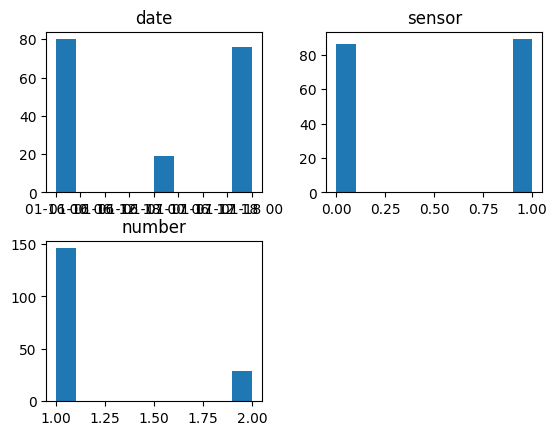

In [194]:
# Show the data distribution
df.hist(grid=False)
plt.show()

#### Group the Dataframe into numerical and categorical columns

In [195]:
# Use numerical_col as variable for the numerical features
numerical_cols = df.select_dtypes(include='number').columns
numerical_cols

Index(['sensor', 'number'], dtype='object')

In [196]:
# Use categorical_col as variable for the categorical features
categorical_cols = df.select_dtypes(include='object').columns
categorical_cols

Index(['time', 'location', 'activity', 'position'], dtype='object')

#### Create a preprocessing pipeline

In [197]:
preprocessor = ColumnTransformer(transformers=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'),categorical_cols),
    ('scaler', StandardScaler(),numerical_cols)
])

In [198]:
# Create a pipeline
k_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2)),
    ('kmeans', KMeans(random_state=42))
])

In [199]:
# To find the optimal number of clusters using the elbow method
wcss =[]
for i in range(1,10):
    k_pipeline.set_params(kmeans=KMeans(n_clusters=i,random_state=42))
    k_pipeline.fit(df)
    wcss.append(k_pipeline.named_steps['kmeans'].inertia_)

##### Use Elbow method to find the optimal number of clusters

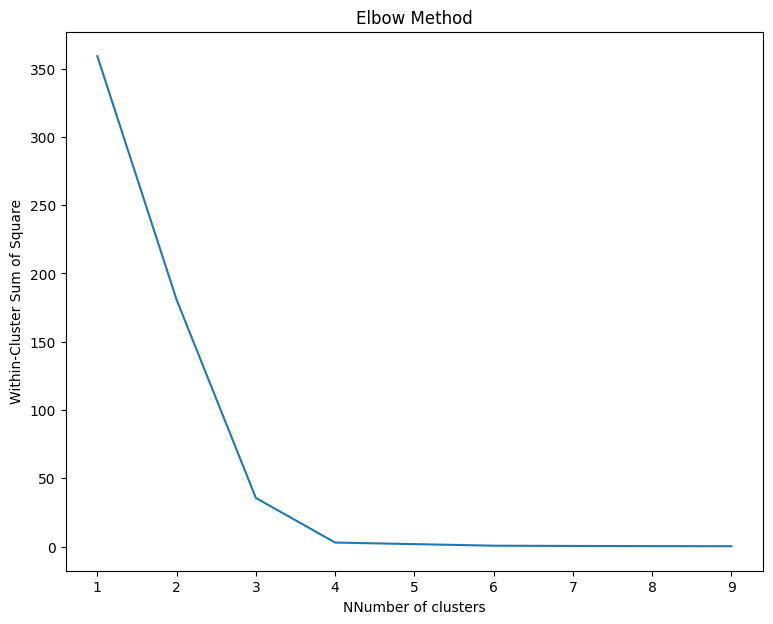

In [200]:
plt.figure(figsize=(9,7))
plt.plot(range(1,10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Square')
plt.show()

### Key Insight

###### From the above elbow method,plot the graph started to flatten after reaching 3 number of clusters.

In [201]:
# Initialize the pipeline with the number of cluster
no_cluster = 3
k_pipeline.set_params(kmeans=KMeans(n_clusters=3, random_state=42))
k_pipeline.fit(df)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['time', 'location', 'activity', 'position'], dtype='object')),
                                                 ('scaler', StandardScaler(),
                                                  Index(['sensor', 'number'], dtype='object'))])),
                ('pca', PCA(n_components=2)),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

In [202]:
# Get the PCA components and transformed data
pca = k_pipeline.named_steps['pca']
df_pca = pca.transform(k_pipeline.named_steps['preprocessor'].transform(df))
pc1 = pca.components_[0]
pc2 = pca.components_[1]

In [203]:
# Get and show the cluster labels
labels = k_pipeline.named_steps['kmeans'].labels_
labels


array([0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [204]:
# To generate  the cluster centers
cluster_centers =  k_pipeline.named_steps['kmeans'].cluster_centers_
cluster_centers

array([[-1.10708328,  0.07508495],
       [ 0.65683357, -0.85482091],
       [ 1.07256248,  1.99484935]])

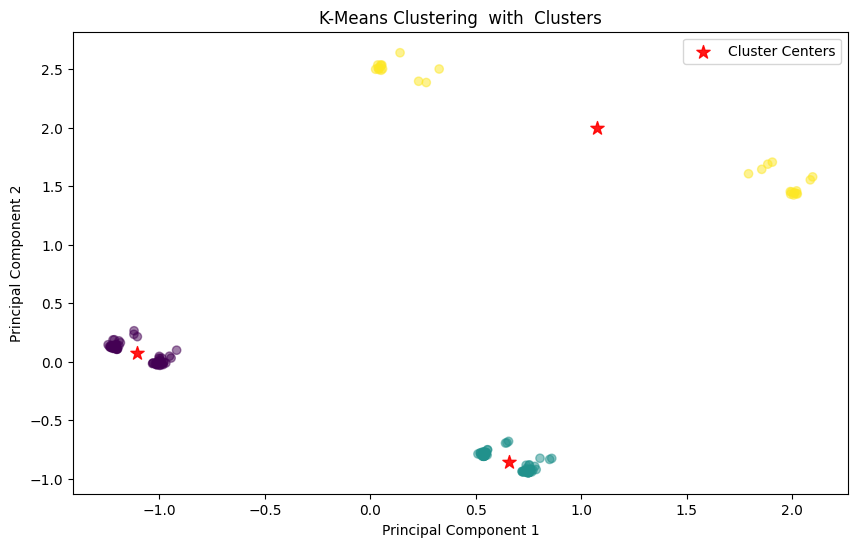

In [205]:
# Plot the clusters with cluster centers
plt.figure(figsize=(10, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=100, alpha=0.9, marker='*', label='Cluster Centers')
plt.title(f'K-Means Clustering  with  Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [206]:
# To find the inertia
k_pipeline.named_steps['kmeans'].inertia_

35.62862418078967

### Key Insight
###### From the inertia value above, the lower the inertia the better the model perfomance

In [207]:
# To evaluate the clustring
silhouette_avg = silhouette_score(df_pca, labels)
calinski_harabasz = calinski_harabasz_score(df_pca, labels)
print(f'Silhouette Score: {silhouette_avg:.3f}')
print(f'Calinski-Harabasz Score: {calinski_harabasz:.3f}')



Silhouette Score: 0.865
Calinski-Harabasz Score: 780.656


#### Key Insights
###### A Silhouette Score of 0.859 above indicates a better defined and well-separated cluster. Thus, it is considered a good clustering result.
###### A Calinski-Harabasz Score of 778.115 is a confirmation that the clusters are compact and well distanced from each other.

In [208]:
# To save the model on the working directory

if not os.path.exists(".\models"):
    os.makedirs(".\models")


joblib.dump(k_pipeline,".\models\kmeans_pipeline.joblib")

['.\\models\\kmeans_pipeline.joblib']